# Hedonic vs Utilitarian classification

pip install missingpy

## First: import necessary libraries and find file names

In [ ]:
import numpy as np
import pandas as pd
import json 
from os import walk

from missingpy import MissForest

from sklearn.manifold import Isomap, TSNE, MDS, LocallyLinearEmbedding
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

mypath='./reviews_features'
_, _, filenames = next(walk(mypath))
print(filenames)

## Lets import our data

In [ ]:
df = pd.DataFrame(
    columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText','overall', 'summary', 'unixReviewTime', 'reviewTime', 'features','amazonCategory'],
)
for name in filenames:  
    temp = pd.read_json(mypath+'/'+name , lines =True)
    temp['amazonCategory'] = name[:-5]
    df = df.append( temp ,ignore_index=True)

**Note that we have stored the category itself in amazonCategory column**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232748 entries, 0 to 232747
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      232748 non-null  object
 1   asin            232748 non-null  object
 2   reviewerName    230910 non-null  object
 3   helpful         232748 non-null  object
 4   reviewText      232748 non-null  object
 5   overall         232748 non-null  object
 6   summary         232748 non-null  object
 7   unixReviewTime  232748 non-null  object
 8   reviewTime      232748 non-null  object
 9   features        232748 non-null  object
 10  amazonCategory  232748 non-null  object
dtypes: object(11)
memory usage: 19.5+ MB


**We don't have any problem reggarding nulls on our features**

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,features,amazonCategory
0,A1JUPR7LPMYG1X,B00009V2QX,"Chef Kim ""My Review""","[0, 0]",Its time for me to purchase another box. great...,4,Great,1356739200,"12 29, 2012","[-0.098792488888888, 0.24677984888888901, 0.37...",health
1,A6YT8ATZ4SEKT,B00009V2QX,C. Moran,"[0, 0]","Recieved OLD black and silver procell package,...",3,recieved OLD STOCK,1401840000,"06 4, 2014","[-0.07366211999999901, 0.345128, 0.30181372, -...",health
2,A0678500JUN3N7KUG4PS,B000056OWW,GigiS,"[0, 0]",The best cold sore remover product I've ever u...,5,Great product.,1403049600,"06 18, 2014","[-0.23953764705882302, 0.21731229411764702, 0....",health
3,A4DRGD09QEE9I,B00009V2QX,"C. R. Dyer ""home maker""","[0, 0]",If you've ever noticed your flashlights are di...,5,Batteries,1357516800,"01 7, 2013","[-0.22847052941176402, 0.270014588235294, 0.45...",health
4,ABT4HGNR22RWO,B00009V2QX,Daniel L. Kellett Sr.,"[0, 0]",Received fast and as described. I have only u...,5,Big bang for your buck...,1320105600,"11 1, 2011","[-0.17499656521739101, 0.29650973913043405, 0....",health


In [5]:
print(pd.unique(df.amazonCategory), len(pd.unique(df.amazonCategory)))

['health' 'sports' 'groceries' 'pet' 'instruments' 'digital_music'
 'movies' 'home' 'baby' 'tools' 'clothing' 'video' 'garden' 'toys'
 'cds_vinyl' 'beauty' 'office' 'electronics' 'kindle' 'automotive'
 'apps_android' 'books' 'games' 'mobile'] 24


**All the categories are correctly imported**

## Data visualizations: just an overview

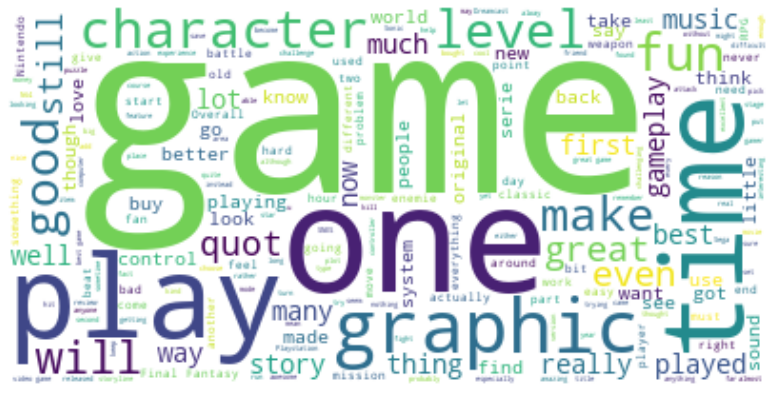

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

text = " ".join(review for review in df.loc[df.amazonCategory=='games'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

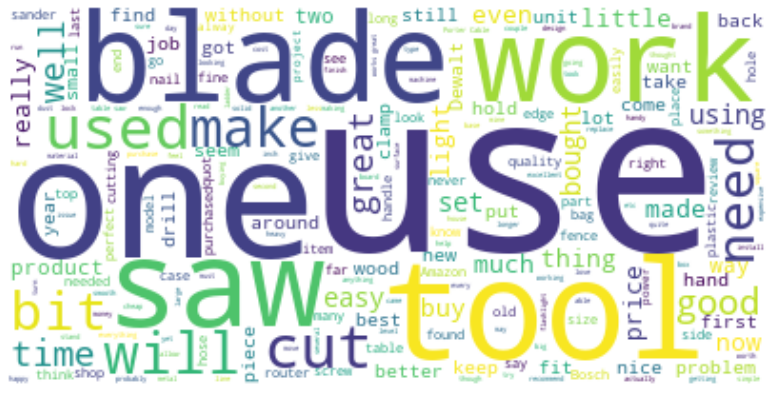

In [7]:
text = " ".join(review for review in df.loc[df.amazonCategory=='tools'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

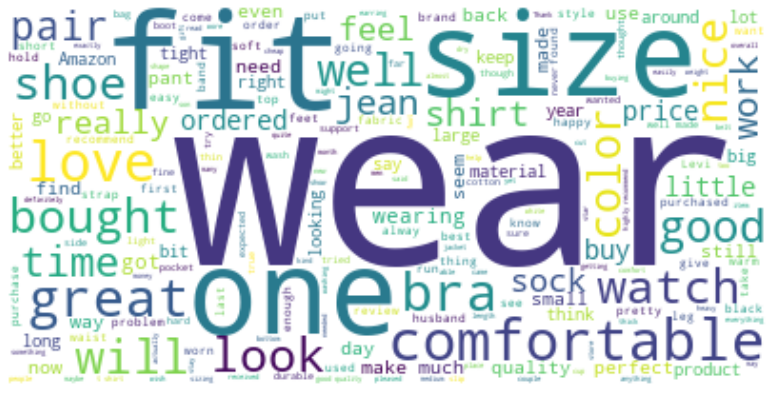

In [8]:
text = " ".join(review for review in df.loc[df.amazonCategory=='clothing'].reviewText)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
df.loc[df.amazonCategory=='games']['reviewText'][212119]

"Back in 1993, a little game called Myst appeared. Everyone went crazy for  it -- it featured amazing graphics, addicting search and explore gameplay,  and it was actually educational. A main part of the game was reading, so it  figures that many parents were so supportive of it. It was also, though,  terribly spooky at times. You could be anywhere in the world of Myst and  still feel a general sense of... well, spookiness.But Myst was in 1993  -- and even though it held well throughout several years (which is  amazingly good), it started to be noticed more as a classic than current  technology.So how well can &quot;Riven: The Sequel To Myst&quot; hold up  against &quot;current technology&quot; and the original classic? By simply  making the adventure more intresting, more long, and with more  &quot;spookiness&quot; -- an original Myst-cliche that adds drama to the  game.&quot;Riven&quot; is even more rewarding than &quot;Myst&quot; so  much to the fact that it is sometimes speechless.

## Impute the categories we already know
### Paper

- Here we have an important note: 

    -> Q1 (quadrand 1) = utilitarian and not hedonic
    
    -> Q2 (quadrand 2) = utilitarian and hedonic
    
    -> Q3 (quadrand 3) = not utilitarian and not hedonic
    
    -> Q4 (quadrand 4) = not utilitarian and hedonic
    
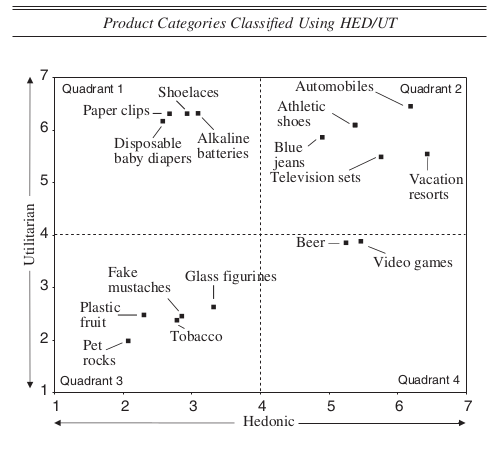

**Note that automobile and video games (Amazon) can be directly inputted in Q2 and Q4 respectively (paper)**

  Here we can identify other possible combinations like inside sports on amazon we will probably find athletic shoes and shoelaces, or inside of home we probably find television sets and glass figurines
  
  But we will have to take a look into each product's name to match them

### Import paper classes

In [10]:
paper_table = pd.read_csv('JMR_paper_table.csv')
paper_table

,name,category
0,shoelaces,Q1
1,paper clips,Q1
2,disposable baby diapers,Q1
3,alkaline batteries,Q1
4,automobiles,Q2
5,athletic shoes,Q2
6,blue jeans,Q2
7,television sets,Q2
8,vacation resorts,Q2
9,glass figurines,Q3


### Inputting nans on our dataset as target label

In [11]:
df['class'] = np.nan

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232748 entries, 0 to 232747
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      232748 non-null  object 
 1   asin            232748 non-null  object 
 2   reviewerName    230910 non-null  object 
 3   helpful         232748 non-null  object 
 4   reviewText      232748 non-null  object 
 5   overall         232748 non-null  object 
 6   summary         232748 non-null  object 
 7   unixReviewTime  232748 non-null  object 
 8   reviewTime      232748 non-null  object 
 9   features        232748 non-null  object 
 10  amazonCategory  232748 non-null  object 
 11  class           0 non-null       float64
dtypes: float64(1), object(11)
memory usage: 21.3+ MB


### Metadata import 
We found a problem here: the product's name is in the metadata and not with the reviews

Inside of metadata title there's the product's name. We will have to face a large problem to join the meta data into the dataset itself

In [13]:
metaPath='./metadata'
_, _, files = next(walk(metaPath))
print(files)

['meta_Patio_Lawn_and_Garden.json', 'meta_Arts_Crafts_and_Sewing.json', 'meta_CDs_and_Vinyl.json', 'meta_Prime_Pantry.json', 'meta_Toys_and_Games.json', 'meta_Industrial_and_Scientific.json', 'meta_Appliances.json', 'meta_Clothing_Shoes_and_Jewelry.json', 'meta_Pet_Supplies.json', 'meta_Books.json', 'meta_Luxury_Beauty.json', 'meta_Cell_Phones_and_Accessories.json', 'meta_Grocery_and_Gourmet_Food.json', 'meta_Tools_and_Home_Improvement.json', 'meta_Sports_and_Outdoors.json', 'meta_Office_Products.json', 'meta_Software.json', 'meta_Kindle_Store.json', 'meta_Home_and_Kitchen.json', 'meta_Magazine_Subscriptions.json', 'meta_Video_Games.json', 'meta_Movies_and_TV.json', 'meta_Automotive.json', 'meta_All_Beauty.json', 'meta_Digital_Music.json', 'meta_AMAZON_FASHION.json', 'meta_Gift_Cards.json', 'meta_Electronics.json', 'meta_Musical_Instruments.json']


In [14]:
desired_columns= ['title', 'description', 'feature', 'asin']
clone = df.reset_index()
result = pd.DataFrame()

for file in files:
    with pd.read_json(metaPath+'/'+file, lines=True, chunksize=20000) as reader:
        reader
        for chunk in reader:
            chunk = chunk[desired_columns]
            temp = clone.merge(chunk, how='inner', on='asin')
            result = pd.concat([result, temp], ignore_index=True)
            print(result.info())

result.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           4517 non-null   int64  
 1   reviewerID      4517 non-null   object 
 2   asin            4517 non-null   object 
 3   reviewerName    4497 non-null   object 
 4   helpful         4517 non-null   object 
 5   reviewText      4517 non-null   object 
 6   overall         4517 non-null   object 
 7   summary         4517 non-null   object 
 8   unixReviewTime  4517 non-null   object 
 9   reviewTime      4517 non-null   object 
 10  features        4517 non-null   object 
 11  amazonCategory  4517 non-null   object 
 12  class           0 non-null      float64
 13  title           4517 non-null   object 
 14  description     4517 non-null   object 
 15  feature         4517 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory usage: 564.8+ KB
None
<class 'panda

,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,features,amazonCategory,class,title,description,feature
0,22347,A1S8HPS1UTJ3TV,B0009IR4CK,Dawn S.,"[2, 3]",I waited a long time to write this review I di...,1,Shitake Mushroom,1355184000,"12 11, 2012","[-0.13535721739130402, 0.317332826086956, 0.36...",groceries,NaN,The Shiitake Mushroom Kit - Indoor Mushroom Gr...,[When buying from Cedarwood Mushrooms: Shiitak...,"[Grow Shiitake Mushrooms at Home, Great Kids P..."
1,22349,A24TAYVE7R87LP,B0009IR4CK,"E. bay ""Northwest bookie""","[1, 1]",We're in the process of doing our shitake grow...,5,"Fun to watch, great to eat, easy to use",1358035200,"01 13, 2013","[-0.24825823636363603, 0.338465436363636, 0.27...",groceries,NaN,The Shiitake Mushroom Kit - Indoor Mushroom Gr...,[When buying from Cedarwood Mushrooms: Shiitak...,"[Grow Shiitake Mushrooms at Home, Great Kids P..."
2,22351,A1E7KO5R4VUDK1,B0009IR4CK,"J. Keith ""janto2""","[0, 0]",It was awkward to grow...there wasn't any room...,3,Loved the shrooms,1360454400,"02 10, 2013","[-0.155770985294117, 0.256016882352941, 0.3467...",groceries,NaN,The Shiitake Mushroom Kit - Indoor Mushroom Gr...,[When buying from Cedarwood Mushrooms: Shiitak...,"[Grow Shiitake Mushrooms at Home, Great Kids P..."
3,22352,A8OSIE7WV9MVG,B0009IR4CK,"KathrynB ""Kathryn""","[23, 29]",My log developed mold spots on it (due to exce...,2,Problems: seller never got backto me,1246579200,"07 3, 2009","[-0.17120985666666602, 0.22301678333333302, 0....",groceries,NaN,The Shiitake Mushroom Kit - Indoor Mushroom Gr...,[When buying from Cedarwood Mushrooms: Shiitak...,"[Grow Shiitake Mushrooms at Home, Great Kids P..."
4,22361,A1C217T6VWIE3,B0009IR4CK,"Mehetabelle ""mehetabelle""","[0, 0]",I gave this kit as a gift so I only have infor...,4,Little mushrooms already emerged!,1356652800,"12 28, 2012","[-0.151629265079365, 0.18714644973544903, 0.35...",groceries,NaN,The Shiitake Mushroom Kit - Indoor Mushroom Gr...,[When buying from Cedarwood Mushrooms: Shiitak...,"[Grow Shiitake Mushrooms at Home, Great Kids P..."


In [15]:
#meta = pd.read_json(metaPath+'/meta_All_Beauty.json', lines =True) # limit to 600mb  meta_AMAZON_FASHION.json
#meta = pd.read_json(metaPath+'/meta_AMAZON_FASHION.json', lines =True)
#desired_columns= ['title', 'description', 'feature', 'asin']
#meta = meta[desired_columns]
#meta.head()

,title,description,feature,asin
0,Loud 'N Clear&trade; Personal Sound Amplifier,[Loud 'N Clear Personal Sound Amplifier allows...,[],6546546450
1,No7 Lift &amp; Luminate Triple Action Serum 50...,[No7 Lift & Luminate Triple Action Serum 50ml ...,[],7178680776
2,No7 Stay Perfect Foundation Cool Vanilla by No7,[No7 Stay Perfect Foundation now stays perfect...,[],7250468162
3,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[],[],7367905066
4,Lacto Calamine Skin Balance Oil control 120 ml...,[Lacto Calamine Skin Balance Daily Nourishing ...,[],7414204790


In [ ]:
#clone = df
#clone = clone.set_index('asin')
#result = clone.merge(meta, how='left', on='asin', suffixes=('', '_y'),indicator=True)
#result.info()

In [ ]:
#result.groupby('_merge').size()

In [ ]:
#result.loc[~(result['_merge'] == 'right_only')].info()

In [ ]:
#result.title.fillna(result.title_y, inplace=True)
#result.description.fillna(result.description_y, inplace=True)
#result.feature.fillna(result.feature_y, inplace=True)

In [ ]:
#result.info()

In [ ]:
#result.drop( columns=['title_y', 'description_y', 'feature_y'], inplace=True)

In [16]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158067 entries, 0 to 158066
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           158067 non-null  int64  
 1   reviewerID      158067 non-null  object 
 2   asin            158067 non-null  object 
 3   reviewerName    157354 non-null  object 
 4   helpful         158067 non-null  object 
 5   reviewText      158067 non-null  object 
 6   overall         158067 non-null  object 
 7   summary         158067 non-null  object 
 8   unixReviewTime  158067 non-null  object 
 9   reviewTime      158067 non-null  object 
 10  features        158067 non-null  object 
 11  amazonCategory  158067 non-null  object 
 12  class           0 non-null       float64
 13  title           158067 non-null  object 
 14  description     157770 non-null  object 
 15  feature         157936 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 19.3+ 

In [17]:
len(pd.unique(result['index']))

106284

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232748 entries, 0 to 232747
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      232748 non-null  object 
 1   asin            232748 non-null  object 
 2   reviewerName    230910 non-null  object 
 3   helpful         232748 non-null  object 
 4   reviewText      232748 non-null  object 
 5   overall         232748 non-null  object 
 6   summary         232748 non-null  object 
 7   unixReviewTime  232748 non-null  object 
 8   reviewTime      232748 non-null  object 
 9   features        232748 non-null  object 
 10  amazonCategory  232748 non-null  object 
 11  class           0 non-null       float64
dtypes: float64(1), object(11)
memory usage: 21.3+ MB


In [19]:
#merged = df.merge(result, how='outer', on='asin')
#merged.info()

In [20]:
len(pd.unique(df.reset_index().merge(result,how='outer',on='index', suffixes=['','_y'])['index']))

232748

In [21]:
x = df.reset_index().merge(result,how='outer',on='index', suffixes=['','_y']).drop_duplicates(subset='index')

In [22]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232748 entries, 0 to 284530
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             232748 non-null  int64  
 1   reviewerID        232748 non-null  object 
 2   asin              232748 non-null  object 
 3   reviewerName      230910 non-null  object 
 4   helpful           232748 non-null  object 
 5   reviewText        232748 non-null  object 
 6   overall           232748 non-null  object 
 7   summary           232748 non-null  object 
 8   unixReviewTime    232748 non-null  object 
 9   reviewTime        232748 non-null  object 
 10  features          232748 non-null  object 
 11  amazonCategory    232748 non-null  object 
 12  class             0 non-null       float64
 13  reviewerID_y      106284 non-null  object 
 14  asin_y            106284 non-null  object 
 15  reviewerName_y    105756 non-null  object 
 16  helpful_y         10

In [23]:
columns_drop=['reviewerID_y', 'asin_y', 'reviewerName_y', 'helpful_y', 'reviewText_y',
       'overall_y', 'summary_y', 'unixReviewTime_y', 'reviewTime_y', 'features_y',
       'amazonCategory_y', 'class_y']

In [24]:
x.drop(columns=columns_drop,inplace=True)

In [25]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232748 entries, 0 to 284530
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           232748 non-null  int64  
 1   reviewerID      232748 non-null  object 
 2   asin            232748 non-null  object 
 3   reviewerName    230910 non-null  object 
 4   helpful         232748 non-null  object 
 5   reviewText      232748 non-null  object 
 6   overall         232748 non-null  object 
 7   summary         232748 non-null  object 
 8   unixReviewTime  232748 non-null  object 
 9   reviewTime      232748 non-null  object 
 10  features        232748 non-null  object 
 11  amazonCategory  232748 non-null  object 
 12  class           0 non-null       float64
 13  title           106284 non-null  object 
 14  description     106115 non-null  object 
 15  feature         106200 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 30.2+ 

### Impute known paper values

In [26]:
x.loc[x.amazonCategory=='games','class'] = 'Q4'

In [27]:
x.loc[x.amazonCategory=='games','class']

255325    Q4
255326    Q4
255327    Q4
255328    Q4
255329    Q4
          ..
273497    Q4
273499    Q4
273501    Q4
273503    Q4
273505    Q4
Name: class, Length: 9885, dtype: object

In [28]:
x.loc[x.amazonCategory=='automotive','class'] = 'Q2'

In [29]:
x.loc[x.amazonCategory=='automotive','class']

224800    Q2
224801    Q2
224802    Q2
224803    Q2
224804    Q2
          ..
236355    Q2
236356    Q2
236357    Q2
236358    Q2
236359    Q2
Name: class, Length: 9969, dtype: object

In [30]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232748 entries, 0 to 284530
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           232748 non-null  int64 
 1   reviewerID      232748 non-null  object
 2   asin            232748 non-null  object
 3   reviewerName    230910 non-null  object
 4   helpful         232748 non-null  object
 5   reviewText      232748 non-null  object
 6   overall         232748 non-null  object
 7   summary         232748 non-null  object
 8   unixReviewTime  232748 non-null  object
 9   reviewTime      232748 non-null  object
 10  features        232748 non-null  object
 11  amazonCategory  232748 non-null  object
 12  class           19854 non-null   object
 13  title           106284 non-null  object
 14  description     106115 non-null  object
 15  feature         106200 non-null  object
dtypes: int64(1), object(15)
memory usage: 30.2+ MB


In [31]:
19854/232748 *100

8.530255899083988

In [32]:
x.loc[~x.title.isna()]['feature']

352       [AN IDEAL, EASY TO USE SCRAPER AND PAD COMBO: ...
354       [AN IDEAL, EASY TO USE SCRAPER AND PAD COMBO: ...
357       [AN IDEAL, EASY TO USE SCRAPER AND PAD COMBO: ...
360       [AN IDEAL, EASY TO USE SCRAPER AND PAD COMBO: ...
362       [AN IDEAL, EASY TO USE SCRAPER AND PAD COMBO: ...
                                ...                        
284526    [iPhone case and battery pack protects and add...
284527    [iPhone case and battery pack protects and add...
284528    [iPhone case and battery pack protects and add...
284529    [iPhone case and battery pack protects and add...
284530    [iPhone case and battery pack protects and add...
Name: feature, Length: 106284, dtype: object

In [33]:
paper_table.name.values

array(['shoelaces', 'paper clips', 'disposable baby diapers',
       'alkaline batteries', 'automobiles', 'athletic shoes',
       'blue jeans', 'television sets', 'vacation resorts',
       'glass figurines', 'fake mustaches', 'plastic fruit', 'pet rocks',
       'tobacco', 'beer', 'video games'], dtype=object)

In [34]:
x['feature']=x['feature'].fillna('').apply(' '.join)

In [35]:
x['description']=x['description'].fillna('').apply(' '.join)

In [36]:
len(x.loc[x.description.str.contains('athletic') & x.description.str.contains('shoe')])

216

In [37]:
x.loc[x.description.str.contains('athletic') & x.description.str.contains('shoe'),'description'].values 
# they are not athletic shoes, they are only socks for sports (not the same=> do not make sense)

array(["Premium comfortable cotton crew length socks feature AquaFX technology to keep feet dry. Full cushion sole provides extra comfort and foot protection. Reinforced comfort toe for long lasting wear which makes this a favorite Gold Toe style. Gold Toe socks are made with only the finest yarns and are carefully reinforced at the heel and toe for longer, more comfortable wear. Machine washable and dryable for easy care. Gold Toe's toe seams are specially flattened for a smooth fit in shoes. Heels are well rounded for gentle support and a comfortable fit. The knit-in gold toe is a registered trademark of Gold Toe and signifies Gold Toe quality, comfort, and fit. Each pair of Gold socks is made with pride by skilled craftsmen and then carefully inspected to offer the customer the finest possible quality. Our Gold Toe Cotton Crew athletic socks are fully cushioned sport socks for all-around activities. Soft, breathable, crew length. USA/Imported. King size is designed with extra length

In [38]:
len(x.loc[x.title.fillna('').str.contains('TV') | x.title.fillna('').str.contains('television')])

466

In [39]:
pd.unique(x.loc[x.title.fillna('').str.contains('TV') | x.title.fillna('').str.contains('television'), 'title'].values)

array(['SEEN ON TV Micro Fiber Miracle Cloth',
       'Epiphone Limited Edition Les Paul Junior Electric Guitar, TV Yellow',
       'Gilmour 813004-1001 TV165753 2-Way Connector, Brass',
       'Tony Bennett - MTV Unplugged: The Video',
       'Special Bulletin TV-Movie  VHS',
       'U2 - Zoo TV Live from Sydney VHS',
       'Barnes &amp; Noble HDTV Adapter Kit for NOOK HD and NOOK HD+',
       'VideoSecu 24" Long Arm TV Wall Mount Low Profile Articulating Full Motion Cantilever Swing Tilt wall bracket for most 22" to 55" LED LCD TV Monitor Flat Screen VESA 200x200 400x400 up to 600x400mm MAH',
       'Barnes &amp; Noble NOOK Tablet 16gb (Color, BNTV250)',
       'ATI Technologies Inc. ATI-TV Wonder NTSC',
       'Barnes &amp; Noble NOOK HD+ Tablet 32GB Slate (BNTV600-32GB)',
       'Sony KV-9PT50 9&quot; Trinitron TV',
       'Monster Cable TGHZ-2RF Two Gigahertz Low-Loss RF Splitters For TV and Satellite 2-Way 2 Gigahertz RF Splitter (Discontinued by Manufacturer)',
       'Monster 

In [40]:
x.loc[x.title=='Sony KV-9PT50 9&quot; Trinitron TV','class'] = 'Q2'

In [41]:
x.loc[x.title=='Sony KV-9PT50 9&quot; Trinitron TV','class']

208899    Q2
208901    Q2
208903    Q2
208905    Q2
208907    Q2
Name: class, dtype: object

In [42]:
x.loc[x.description.fillna('').str.contains('diapers'), 'description'] ### this is diapers for dogs hahahah

40502    Simple Solution Disposable Light Absorbency Di...
40508    Simple Solution Disposable Light Absorbency Di...
40629    Simple Solution Disposable Light Absorbency Di...
40631    Simple Solution Disposable Light Absorbency Di...
40633    Simple Solution Disposable Light Absorbency Di...
40635    Simple Solution Disposable Light Absorbency Di...
40641    Simple Solution Disposable Light Absorbency Di...
40643    Simple Solution Disposable Light Absorbency Di...
40645    Simple Solution Disposable Light Absorbency Di...
Name: description, dtype: object

In [43]:
x.loc[x.description.fillna('').str.contains('batteries') & x.description.fillna('').str.contains('alkaline'), 'title']
# does not seam to be right 

54744     [DISCONTINUED] Vox APJS amPlug Joe Satriani Gu...
54753     [DISCONTINUED] Vox APJS amPlug Joe Satriani Gu...
54755     [DISCONTINUED] Vox APJS amPlug Joe Satriani Gu...
54985     [DISCONTINUED] Vox APJS amPlug Joe Satriani Gu...
54986     [DISCONTINUED] Vox APJS amPlug Joe Satriani Gu...
                                ...                        
210466    Nikon Coolpix 800 2MP Digital Camera w/ 2x Opt...
210468    Nikon Coolpix 800 2MP Digital Camera w/ 2x Opt...
210470    Nikon Coolpix 800 2MP Digital Camera w/ 2x Opt...
210472    Nikon Coolpix 800 2MP Digital Camera w/ 2x Opt...
210474    Nikon Coolpix 800 2MP Digital Camera w/ 2x Opt...
Name: title, Length: 108, dtype: object

In [44]:
x.loc[x.title.fillna('').str.contains('paper') & x.title.fillna('').str.contains('clips'), 'title'].values

array([], dtype=object)

In [45]:
pd.unique(x.loc[x.description.fillna('').str.contains('paper') & x.description.fillna('').str.contains('clips'), 'title'].values)

array(['ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)',
       'ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)',
       'Rolodex Mesh Collection 3-Tier Swivel Tower Sorter, Black (62533)',
       'OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)',
       'iPad Pro 10.5 Case with wireless Keyboard, Janvvoo Ultra-thin lightweight bluetooth keyboard with Magnetically Intelligent Switch and Multi-Angle Stand for Apple iPad Pro 10.5 inch Tablet',
       'TMOBILE POSTPAID MOTOROLA V330',
       'Verizon or PagePlus LG VX8300 Great Condition MP3 3G Camera CDMA Flip Cell Phone',
       'Motorola RAZR V3 Unlocked Phone with Camera, and Video Player--U.S. Version with Warranty (Blue)',
       'Motorola RAZR V3 2G Unlocked Phone with Camera, and Video Player -This phone will not work for AT&amp;T or Any AT&amp;T sub-carriers.',
       'Motorola RAZR V3 Unlocked GSM Phone  with Camera and Video Player U.S. Version with Warranty (Silver)',
     

In [46]:
x.loc[x.title=='ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)','class'] = 'Q1'
x.loc[x.title=='ACCO Binder Clips, Mini, 1 Box, 12 Clips/Box (72010)','class']

184362    Q1
184366    Q1
184369    Q1
184371    Q1
184382    Q1
184384    Q1
184386    Q1
184388    Q1
184390    Q1
184392    Q1
184394    Q1
184396    Q1
184398    Q1
184400    Q1
184402    Q1
184404    Q1
184406    Q1
184408    Q1
184410    Q1
184412    Q1
184415    Q1
184417    Q1
184419    Q1
184421    Q1
184423    Q1
184425    Q1
184427    Q1
184429    Q1
184431    Q1
197910    Q1
197912    Q1
197914    Q1
197916    Q1
197921    Q1
197923    Q1
197925    Q1
197927    Q1
197929    Q1
197931    Q1
197933    Q1
197935    Q1
197937    Q1
197939    Q1
197941    Q1
197943    Q1
Name: class, dtype: object

In [47]:
x.loc[x.title=='ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)','class'] = 'Q1'
x.loc[x.title=='ACCO Paper Clips, Jumbo, Smooth, Economy, 10 Boxes, 100/Box (72580)','class']

184433    Q1
184435    Q1
184437    Q1
184439    Q1
184441    Q1
184443    Q1
184445    Q1
184447    Q1
184451    Q1
Name: class, dtype: object

In [48]:
x.loc[x.title=='OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)','class'] = 'Q1'
x.loc[x.title=='OfficemateOIC Mini Binder Clips, Assorted Colors, 60 Clips per Tub (31024)','class']

197892    Q1
197894    Q1
197896    Q1
197898    Q1
197900    Q1
Name: class, dtype: object

In [49]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232748 entries, 0 to 284530
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           232748 non-null  int64 
 1   reviewerID      232748 non-null  object
 2   asin            232748 non-null  object
 3   reviewerName    230910 non-null  object
 4   helpful         232748 non-null  object
 5   reviewText      232748 non-null  object
 6   overall         232748 non-null  object
 7   summary         232748 non-null  object
 8   unixReviewTime  232748 non-null  object
 9   reviewTime      232748 non-null  object
 10  features        232748 non-null  object
 11  amazonCategory  232748 non-null  object
 12  class           19918 non-null   object
 13  title           106284 non-null  object
 14  description     232748 non-null  object
 15  feature         232748 non-null  object
dtypes: int64(1), object(15)
memory usage: 30.2+ MB


### Prepare for imputation (cleaning & droppings)

In [50]:
19918 / 232748 *100

8.557753450083352

In [51]:
x.features

0         [-0.098792488888888, 0.24677984888888901, 0.37...
1         [-0.07366211999999901, 0.345128, 0.30181372, -...
2         [-0.23953764705882302, 0.21731229411764702, 0....
3         [-0.22847052941176402, 0.270014588235294, 0.45...
4         [-0.17499656521739101, 0.29650973913043405, 0....
                                ...                        
284526    [-0.186513880512091, 0.099456939260313, 0.3935...
284527    [-0.212278070175438, 0.177555192982456, 0.3903...
284528    [-0.116286019607843, 0.29573325686274504, 0.40...
284529    [-0.093076385542168, 0.14522663674698802, 0.37...
284530    [-0.18077335820895502, 0.171594502976119, 0.29...
Name: features, Length: 232748, dtype: object

In [52]:
len(x.features[1])

119

In [53]:
x.to_json('data_and_meta.json')

In [54]:
l = x.features.tolist()

In [55]:
data = pd.DataFrame(l,columns=[i for i in range(len(x.features[1]))])
data

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,-0.098792,0.246780,0.372182,-0.267302,-0.093455,0.154483,-0.149150,0.133048,-0.161907,-0.061863,...,1.440184,0.000803,0.799012,0.216770,0.488889,0.288604,2,0.977778,3.893833,0.022222
1,-0.073662,0.345128,0.301814,-0.476560,0.025313,0.079780,-0.086261,0.161001,-0.147534,0.065079,...,1.450185,0.001706,0.643200,0.207359,0.480000,0.288444,1,1.000000,3.384134,0.000000
2,-0.239538,0.217312,0.391495,-0.259332,-0.096260,0.049797,-0.015582,0.133139,-0.179384,-0.108626,...,1.451828,-0.001383,0.581315,0.272105,0.470588,0.288175,3,0.882353,3.008596,0.117647
3,-0.228471,0.270015,0.455785,-0.271271,0.050026,0.108745,-0.159302,0.216017,-0.107940,-0.053101,...,1.355809,0.000455,0.698962,0.227270,0.470588,0.288175,1,1.000000,3.486968,0.000000
4,-0.174997,0.296510,0.258443,-0.317369,-0.158371,0.158997,-0.053249,0.170265,-0.081173,-0.090188,...,1.428191,0.000666,0.896030,0.083818,0.478261,0.288402,1,1.000000,4.280255,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232743,-0.186514,0.099457,0.393527,-0.186841,0.037206,0.140150,-0.143451,0.161884,-0.102061,0.058485,...,1.430721,0.000060,0.647394,0.252082,0.499289,0.288675,2,0.998578,3.321696,0.001422
232744,-0.212278,0.177555,0.390303,-0.246410,-0.130181,0.186109,-0.030990,0.232672,-0.103300,0.034690,...,1.444015,-0.000015,0.784241,0.210243,0.491228,0.288631,2,0.982456,3.925651,0.017544
232745,-0.116286,0.295733,0.404483,-0.161157,-0.175289,0.202572,-0.013252,0.300210,0.076071,-0.095648,...,1.437150,0.000151,0.836601,0.142492,0.490196,0.288620,1,1.000000,4.070854,0.000000
232746,-0.093076,0.145227,0.372964,-0.218381,-0.008757,0.194206,-0.045708,0.268212,-0.103843,0.044485,...,1.439036,-0.000085,0.789229,0.211758,0.496988,0.288670,2,0.993976,3.903552,0.006024


In [56]:
data['class'] = x['class'].reset_index().drop(columns='index')

In [57]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,class
0,-0.098792,0.246780,0.372182,-0.267302,-0.093455,0.154483,-0.149150,0.133048,-0.161907,-0.061863,...,0.000803,0.799012,0.216770,0.488889,0.288604,2,0.977778,3.893833,0.022222,NaN
1,-0.073662,0.345128,0.301814,-0.476560,0.025313,0.079780,-0.086261,0.161001,-0.147534,0.065079,...,0.001706,0.643200,0.207359,0.480000,0.288444,1,1.000000,3.384134,0.000000,NaN
2,-0.239538,0.217312,0.391495,-0.259332,-0.096260,0.049797,-0.015582,0.133139,-0.179384,-0.108626,...,-0.001383,0.581315,0.272105,0.470588,0.288175,3,0.882353,3.008596,0.117647,NaN
3,-0.228471,0.270015,0.455785,-0.271271,0.050026,0.108745,-0.159302,0.216017,-0.107940,-0.053101,...,0.000455,0.698962,0.227270,0.470588,0.288175,1,1.000000,3.486968,0.000000,NaN
4,-0.174997,0.296510,0.258443,-0.317369,-0.158371,0.158997,-0.053249,0.170265,-0.081173,-0.090188,...,0.000666,0.896030,0.083818,0.478261,0.288402,1,1.000000,4.280255,0.000000,NaN


In [58]:
classes = data['class']

In [59]:
data.to_json('features_label.json')

In [66]:
categorical = ['class']
numerical = []
X=data
X[categorical] = X[categorical].apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))


print(data)

#imp_num = IterativeImputer(estimator=RandomForestRegressor(),
#                           initial_strategy='mean',
#                           max_iter=10, random_state=0)

imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                           initial_strategy='mean',
                           max_iter=30, random_state=42)

#data[numerical] = imp_num.fit_transform(data[numerical])
data[categorical] = imp_cat.fit_transform(data[categorical])

print(data)

               0         1         2         3         4         5         6  \
0      -0.098792  0.246780  0.372182 -0.267302 -0.093455  0.154483 -0.149150   
1      -0.073662  0.345128  0.301814 -0.476560  0.025313  0.079780 -0.086261   
2      -0.239538  0.217312  0.391495 -0.259332 -0.096260  0.049797 -0.015582   
3      -0.228471  0.270015  0.455785 -0.271271  0.050026  0.108745 -0.159302   
4      -0.174997  0.296510  0.258443 -0.317369 -0.158371  0.158997 -0.053249   
...          ...       ...       ...       ...       ...       ...       ...   
232743 -0.186514  0.099457  0.393527 -0.186841  0.037206  0.140150 -0.143451   
232744 -0.212278  0.177555  0.390303 -0.246410 -0.130181  0.186109 -0.030990   
232745 -0.116286  0.295733  0.404483 -0.161157 -0.175289  0.202572 -0.013252   
232746 -0.093076  0.145227  0.372964 -0.218381 -0.008757  0.194206 -0.045708   
232747 -0.180773  0.171595  0.292866 -0.165053  0.051154  0.117303 -0.056381   

               7         8         9  .

In [68]:
x.groupby('class').size()

class
Q1      59
Q2    9974
Q4    9885
dtype: int64

In [69]:
#categorical = ['class']
#imputer = MissForest()
#X= pd.DataFrame(l,columns=[i for i in range(len(x.features[1]))])
#X['class'] = x['class'].reset_index().drop(columns='index')

#X[categorical] = X[categorical].apply(lambda series: pd.Series(
#    LabelEncoder().fit_transform(series[series.notnull()]),
#    index=series[series.notnull()].index
#))

#X_imputed = imputer.fit_transform(X)
#X_imputed

In [ ]:
df = pd.read_json('features_label.json')
df.info()

In [ ]:
#df.loc[~df['class'].isnull()]

In [ ]:
df['class'] = df['class'].astype('category')

In [ ]:
df.head()

In [ ]:
df.groupby('class').size()

In [ ]:
from sklearn import preprocessing
categorical = ['class']
le = preprocessing.LabelEncoder()
df[categorical] = df[categorical].apply(lambda series: pd.Series(
    le.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

In [ ]:
%%time

imputer = MissForest(random_state=42, class_weight='balanced')
imputed = imputer.fit_transform(df, cat_vars=119)
imputed

In [ ]:
cat_cols=['class']
imputed = pd.DataFrame(imputed, columns=df.columns.tolist())

imputed.describe(include='all')

In [ ]:
imputed.groupby('class').size()

In [ ]:
metadata = pd.read_json('data_and_meta.json').reset_index()
metadata.info()

In [ ]:
metadata['CLASS'] = imputed['class']
metadata.loc[~metadata.title.isnull() & (metadata.CLASS == 2)].iloc[100]

In [ ]:
metadata['CLASS'] = le.inverse_transform(imputed['class'].astype(int)[imputed['class'].notnull()])

In [ ]:
metadata